In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D # Changed import statement
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip install chart_studio
import chart_studio.plotly as py # Use this module instead
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
import tensorflow as tf #Added this line to import tensorflow
tf.random.set_seed(1) # Changed to tf.random.set_seed
from numpy.random import seed
seed(1)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 928.1 kB/s eta 0:00:00


In [ ]:
train = pd.read_csv('/content/train.csv', parse_dates=['date']) # Ensure the 'date' column is parsed as datetime objects
test = pd.read_csv('/content/test.csv', parse_dates=['date'])

In [ ]:
print(train.describe())
print(train.head())

                                date          store           item  \
count                         116006  116006.000000  116006.000000   
mean   2015-06-28 22:05:09.956381440       5.322207       3.694481   
min              2013-01-01 00:00:00       1.000000       1.000000   
25%              2014-03-30 00:00:00       3.000000       2.000000   
50%              2015-06-26 00:00:00       5.000000       4.000000   
75%              2016-09-27 00:00:00       8.000000       5.000000   
max              2017-12-31 00:00:00      10.000000       7.000000   
std                              NaN       2.896336       1.843228   

               sales  
count  116006.000000  
mean       37.551497  
min         0.000000  
25%        20.000000  
50%        31.000000  
75%        51.000000  
max       150.000000  
std        22.771950  
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     

In [ ]:
# Handle potential errors during conversion
train['date'] = pd.to_datetime(train['date'], errors='coerce')

# Identify the problematic rows
invalid_dates = train[train['date'].isnull()]
print(invalid_dates)

# Display date range in the train set
print('Min date from train set:', train['date'].min().date())
print('Max date from train set:', train['date'].max().date())

Empty DataFrame
Columns: [date, store, item, sales]
Index: []
Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [ ]:
# Calculate the lag size
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Forecast lag size:', lag_size)

Forecast lag size: 90


In [ ]:
# Aggregate daily sales data
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:
# Plot daily sales
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [ ]:
# Plot store daily sales
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[store_daily_sales['store'] == store]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=f'Store {store}'))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

In [ ]:
# Plot item daily sales
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[item_daily_sales['item'] == item]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=f'Item {item}'))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

In [ ]:
train = train[(train['date'] >= '2017-01-01')]

In [ ]:
# Group the train data
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False).agg({'sales': ['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# Convert series to supervised learning format
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)

In [ ]:
# Filter the series data
last_item = f'item(t-{window})'
last_store = f'store(t-{window})'
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]
columns_to_drop = [f'{col}(t+{lag})' for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [f'{col}(t-{i})' for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [ ]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (12646, 30)
Validation set shape (8432, 30)


sales(t-29)  sales(t-28)  sales(t-27)  sales(t-26)  sales(t-25)  \
14009         32.0         29.0         27.0         25.0         27.0   
7963          43.0         42.0         59.0         56.0         50.0   
6485         103.0        102.0         69.0         85.0         74.0   
10648         34.0         49.0         35.0         29.0         28.0   
1760          21.0         17.0         17.0         23.0         18.0   

       sales(t-24)  sales(t-23)  sales(t-22)  sales(t-21)  sales(t-20)  ...  \
14009         31.0         20.0         33.0         27.0         41.0  ...   
7963          47.0         47.0         45.0         32.0         52.0  ...   
6485          74.0         87.0        104.0        112.0         84.0  ...   
10648         20.0         41.0         42.0         30.0         29.0  ...   
1760          20.0         26.0         16.0         19.0         30.0  ...   

       sales(t-9)  sales(t-8)  sales(t-7)  sales(t-6)  sales(t-5)  sales(t-4)  \
14009        35.0        25.0        41.0        42.0        20.0        18.0   
7963         48.0        52.0        54.0        53.0        63.0        76.0   
6485         93.0        99.0       103.0        53.0        79.0        80.0   
10648        37.0        24.0        35.0        21.0        38.0        44.0   
1760         19.0        19.0        21.0        29.0        14.0         8.0   

       sales(t-3)  sales(t-2)  sales(t-1)  sales(t)  
14009        26.0        37.0        30.0      39.0  
7963         44.0        46.0        54.0      46.0  
6485         65.0        85.0        79.0     100.0  
10648        36.0        53.0        49.0      63.0  
1760         20.0        17.0        18.0      27.0  

[5 rows x 30 columns]

In [ ]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
396/396 - 1s - loss: 470.6160 - val_loss: 246.4953 - 1s/epoch - 3ms/step
Epoch 2/40
396/396 - 1s - loss: 246.2344 - val_loss: 231.4361 - 634ms/epoch - 2ms/step
Epoch 3/40
396/396 - 1s - loss: 237.3911 - val_loss: 226.2401 - 634ms/epoch - 2ms/step
Epoch 4/40
396/396 - 1s - loss: 232.3889 - val_loss: 227.0073 - 619ms/epoch - 2ms/step
Epoch 5/40
396/396 - 1s - loss: 229.3875 - val_loss: 218.7982 - 625ms/epoch - 2ms/step
Epoch 6/40
396/396 - 1s - loss: 225.5106 - val_loss: 224.5324 - 628ms/epoch - 2ms/step
Epoch 7/40
396/396 - 1s - loss: 223.5965 - val_loss: 246.6380 - 622ms/epoch - 2ms/step
Epoch 8/40
396/396 - 1s - loss: 223.7939 - val_loss: 220.2604 - 630ms/epoch - 2ms/step
Epoch 9/40
396/396 - 1s - loss: 222.5082 - val_loss: 215.0395 - 621ms/epoch - 2ms/step
Epoch 10/40
396/396 - 1s - loss: 220.7927 - val_loss: 226.5832 - 625ms/epoch - 2ms/step
Epoch 11/40
396/396 - 1s - loss: 219.9267 - val_loss: 223.5542 - 611ms/epoch - 2ms/step
Epoch 12/40
396/396 - 1s - loss: 218.6931 - 

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (12646, 30, 1)
Validation set shape (8432, 30, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                44850     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45093 (176.14 KB)
Trainable params: 45093 (176.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

# Create the optimizer
adam = tf.keras.optimizers.Adam() # Assuming adam is intended to be the Adam optimizer

# Compile the model and explicitly pass the variables
model_cnn.compile(loss='mse', optimizer=adam)
adam.build(model_cnn.trainable_variables)

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 896)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                44850     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45093 (176.14 KB)
Trainable params: 45093 (176.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Ensure the optimizer is aware of the LSTM model's variables
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
adam = tf.keras.optimizers.Adam() # Create a new optimizer instance for the LSTM model
model_lstm.compile(loss='mse', optimizer=adam) # Compile the model with the new optimizer instance
model_lstm.summary()

lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
396/396 - 6s - loss: 801.9621 - val_loss: 881.3634 - 6s/epoch - 14ms/step
Epoch 2/40
396/396 - 4s - loss: 454.2747 - val_loss: 442.2470 - 4s/epoch - 11ms/step
Epoch 3/40
396/396 - 4s - loss: 407.3011 - val_loss: 362.5564 - 4s/epoch - 11ms/step
Epoch 4/40
396/396 - 4s - loss: 335.7063 - val_loss: 329.3502 - 4s/epoch - 11ms/step
Epoch 5/40
396/396 - 5s - loss: 309.6716 - val_loss: 296.7285 - 5s/epoch -

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (12646, 2, 15, 1)
Validation set shape (8432, 2, 15, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
adam = tf.keras.optimizers.Adam() # Create a new optimizer instance for the CNN-LSTM model
model_cnn_lstm.compile(loss='mse', optimizer=adam) # Compile the model with the new optimizer instance

In [ ]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

264/264 [==============================] - 0s 920us/step
Train rmse: 14.234816884310153
Validation rmse: 14.207684578723518


In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

264/264 [==============================] - 0s 1ms/step
Train rmse: 52.17162861524533
Validation rmse: 51.900567819472876


In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

264/264 [==============================] - 0s 1ms/step
Train rmse: 15.694455709276504
Validation rmse: 51.900567819472876


In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

264/264 [==============================] - 1s 2ms/step
Train rmse: 47.20542709993679
Validation rmse: 46.98312335103151


ACCURACY


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

def calculate_accuracy(y_true, y_pred):
    """Calculates the accuracy percentage."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    accuracy = 100 - (rmse / np.mean(y_true)) * 100
    return accuracy

history = model_lstm.fit(X_train_series, Y_train, epochs=100, batch_size=64, validation_data=(X_valid_series, Y_valid), callbacks=[early_stopping])

lstm_valid_pred = model_lstm.predict(X_valid_series)

accuracy = calculate_accuracy(Y_valid, lstm_valid_pred)
print(f'Validation accuracy: {accuracy:.2f}%')


Epoch 1/100
198/198 [==============================] - 19s 76ms/step - loss: 1170.8290 - val_loss: 794.5537
Epoch 2/100
198/198 [==============================] - 14s 69ms/step - loss: 699.2690 - val_loss: 613.0748
Epoch 3/100
198/198 [==============================] - 14s 71ms/step - loss: 501.0390 - val_loss: 379.3925
Epoch 4/100
198/198 [==============================] - 14s 71ms/step - loss: 343.3322 - val_loss: 300.5963
Epoch 5/100
198/198 [==============================] - 14s 70ms/step - loss: 288.4354 - val_loss: 266.8610
Epoch 6/100
198/198 [==============================] - 14s 71ms/step - loss: 266.5009 - val_loss: 248.7856
Epoch 7/100
198/198 [==============================] - 14s 71ms/step - loss: 250.0610 - val_loss: 241.5897
Epoch 8/100
198/198 [==============================] - 14s 69ms/step - loss: 244.1172 - val_loss: 235.8234
Epoch 9/100
198/198 [==============================] - 14s 71ms/step - loss: 239.9280 - val_loss: 229.6073
Epoch 10/100
198/198 [==============

SALES GRAPH OF EVERY YEAR

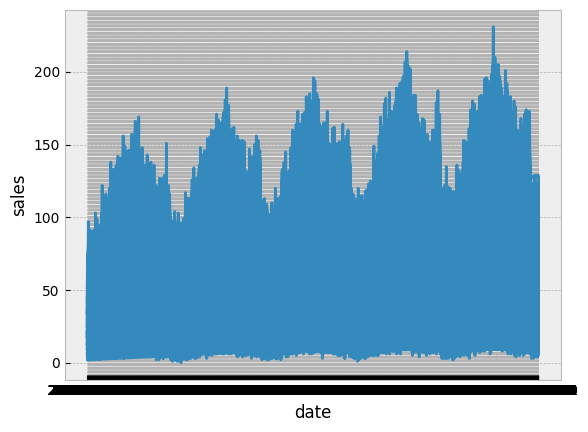

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('bmh')
df=pd.read_csv('/content/train.csv')

x=df['date']
y=df['sales']

plt.xlabel('date')
plt.ylabel('sales')
plt.plot(x,y)

SALES GRAPH FOR PARTICULAR MONTH FOR EACH YEAR

Enter the month (in MM format): 05


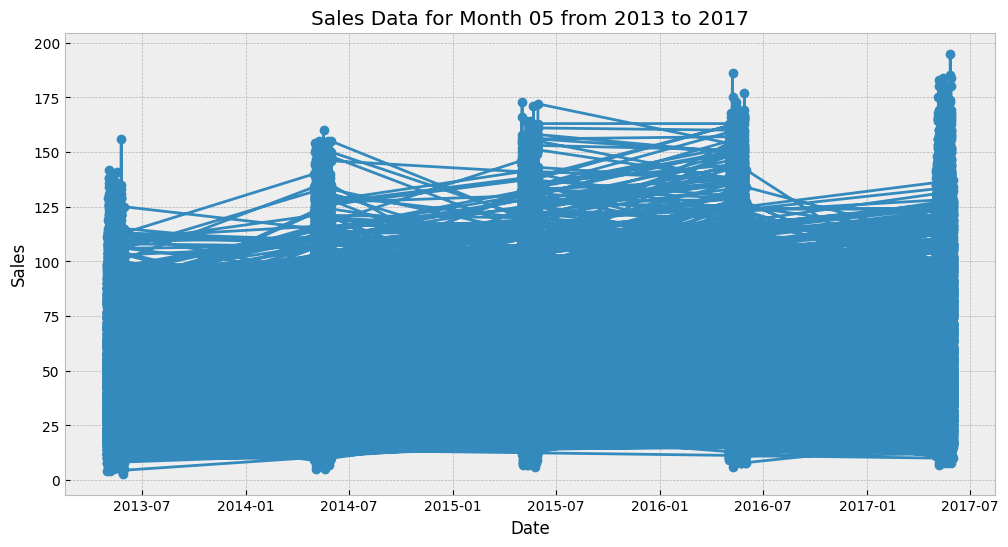

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/train.csv')

df['date'] = pd.to_datetime(df['date'])

month = input("Enter the month (in MM format): ")

filtered_df = df[df['date'].dt.month.astype(str).str.zfill(2) == month]

x = filtered_df['date']
y = filtered_df['sales']

plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Sales Data for Month {month} from 2013 to 2017')
plt.plot(x, y, marker='o', linestyle='-')
plt.grid(True)
plt.show()


SALES GRAPH FOR EACH QUATER FROM 2013 TO 2017

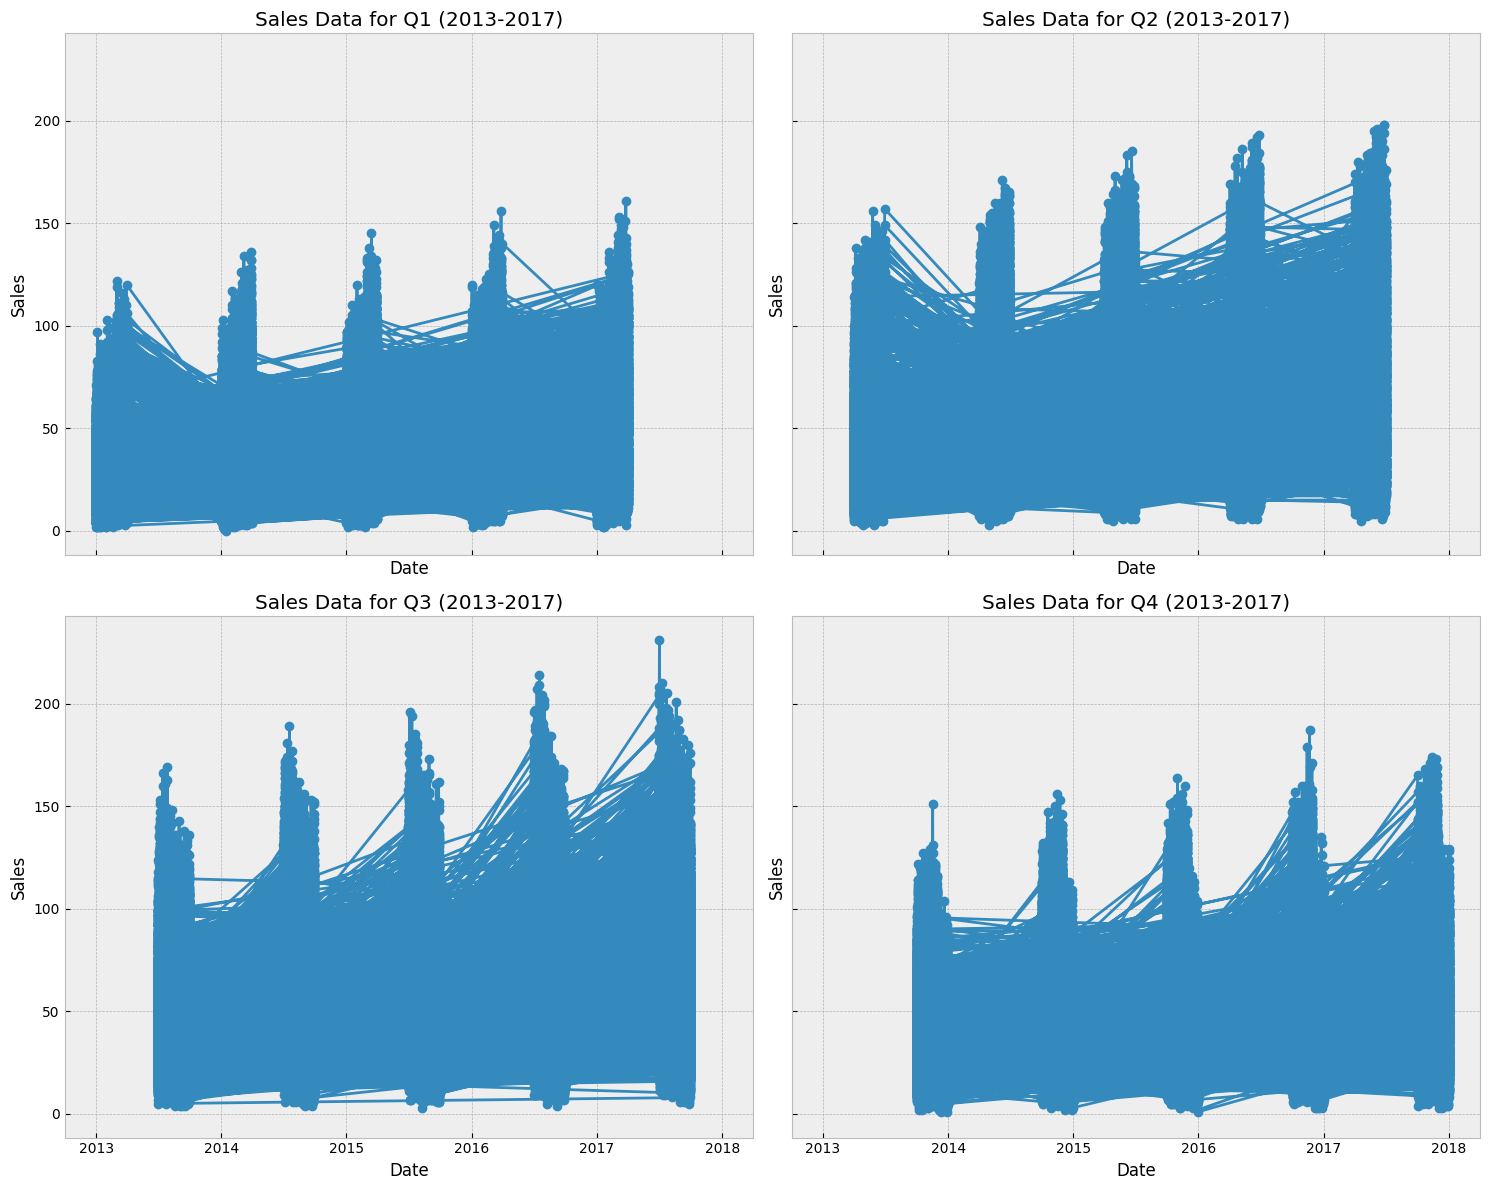

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/train.csv')

df['date'] = pd.to_datetime(df['date'])

quarters = {
    'Q1': [1, 2, 3],
    'Q2': [4, 5, 6],
    'Q3': [7, 8, 9],
    'Q4': [10, 11, 12]
}

df = df[df['date'].dt.year.between(2013, 2017)]

fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (quarter, months) in enumerate(quarters.items()):
    quarter_data = df[df['date'].dt.month.isin(months)]
    x = quarter_data['date']
    y = quarter_data['sales']

    axes[i].plot(x, y, marker='o', linestyle='-')
    axes[i].set_title(f'Sales Data for {quarter} (2013-2017)')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


SALES GRAPH FOR PARTICULAR ITEM FOR EACH QUATER

Enter the store number: 5
Enter the item numbers separated by commas: 46


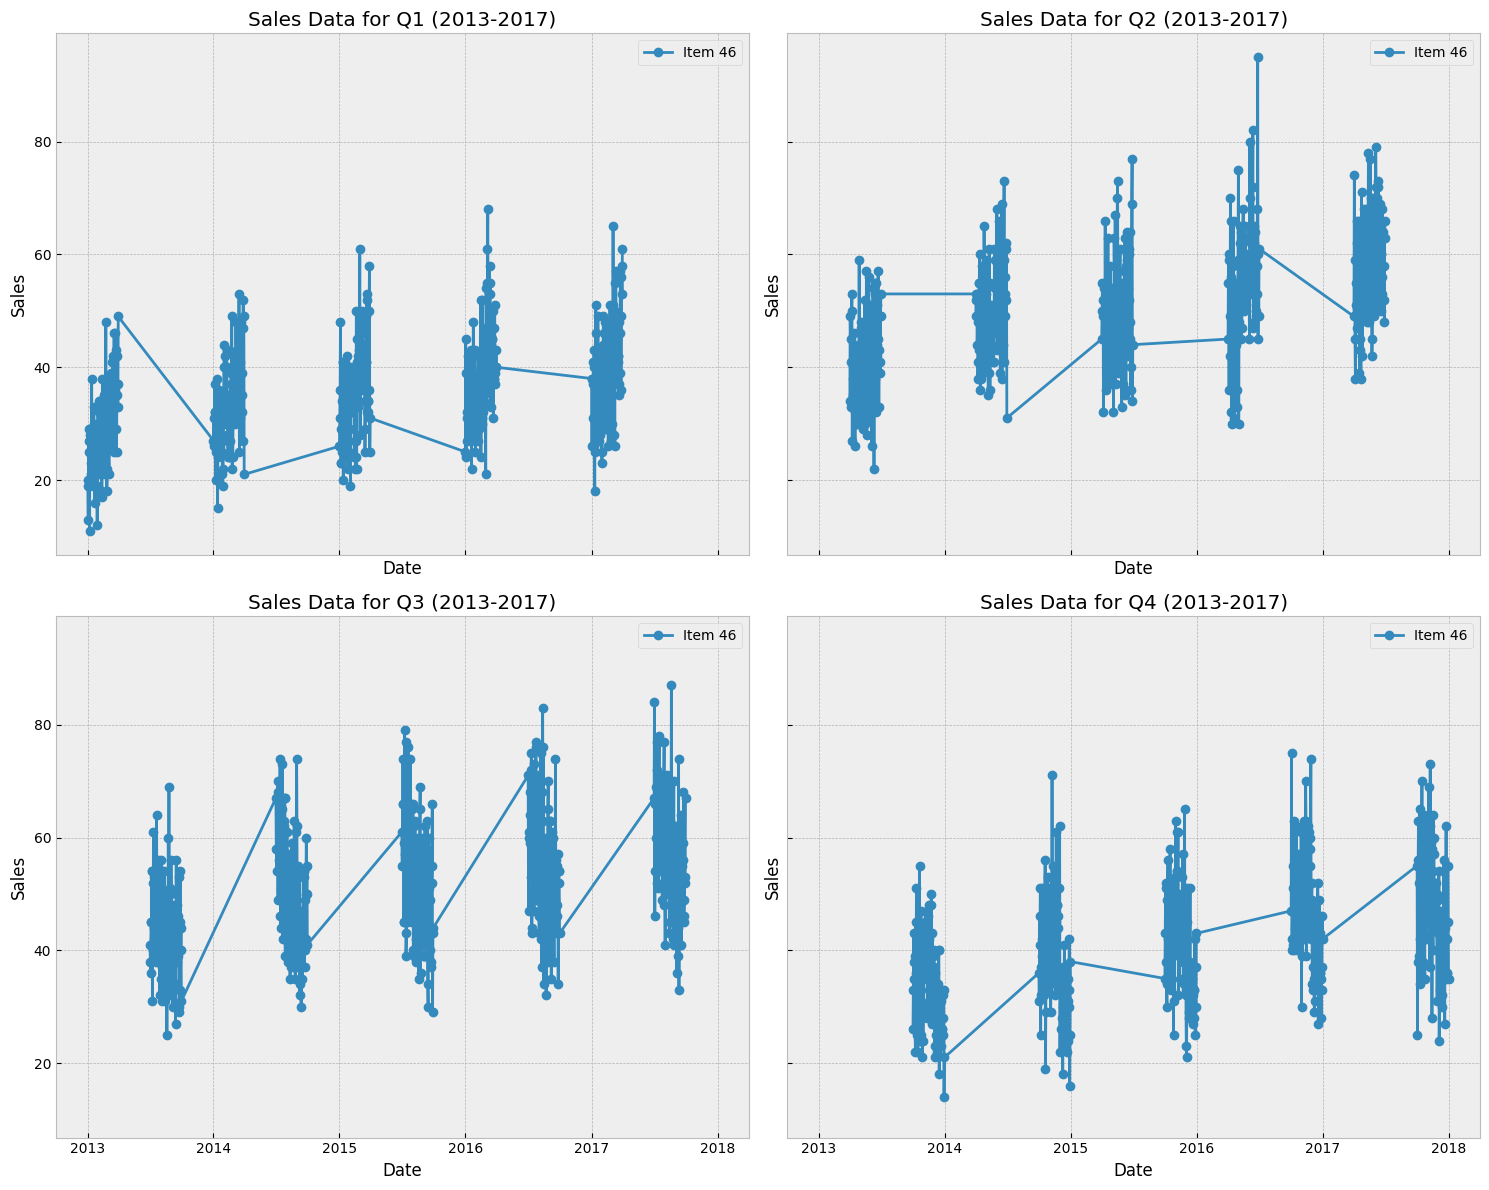

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def validate_input(value, data_type, min_value=None):
    """Validates user input."""
    while True:
        try:
            converted_value = data_type(value)
            if min_value is not None and converted_value < min_value:
                raise ValueError("Value must be greater than or equal to {}".format(min_value))
            return converted_value
        except ValueError as e:
            print("Invalid input. Please enter a valid {}: ".format(data_type.__name__), e)
            value = input()

train = pd.read_csv('/content/train.csv', parse_dates=['date'])

quarters = {
    'Q1': [1, 2, 3],
    'Q2': [4, 5, 6],
    'Q3': [7, 8, 9],
    'Q4': [10, 11, 12]
}

store = validate_input(input("Enter the store number: "), int, min_value=1) # Call the newly defined function
items = input("Enter the item numbers separated by commas: ").split(',')
items = [validate_input(item.strip(), int, min_value=1) for item in items]

filtered_df = train[(train['store'] == store) & (train['item'].isin(items)) & (train['date'].dt.year.between(2013, 2017))]

fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (quarter, months) in enumerate(quarters.items()):
    quarter_data = filtered_df[filtered_df['date'].dt.month.isin(months)]

    for item in items:
        item_data = quarter_data[quarter_data['item'] == item]
        axes[i].plot(item_data['date'], item_data['sales'], marker='o', linestyle='-', label=f'Item {item}')

    axes[i].set_title(f'Sales Data for {quarter} (2013-2017)')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

SALES PREDICTION GRAPH FOR A PARICULAR ITEM FROM A PARTICULAR STORE

Enter the store number: 7
Enter the item numbers separated by commas: 39
Enter the month (in MM format): 05
1/1 [==============================] - 0s 22ms/step


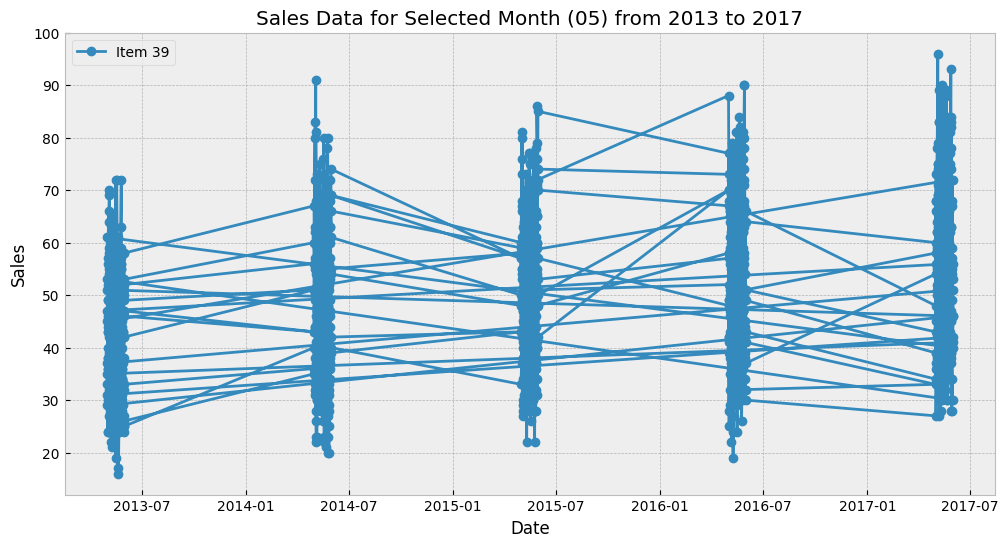

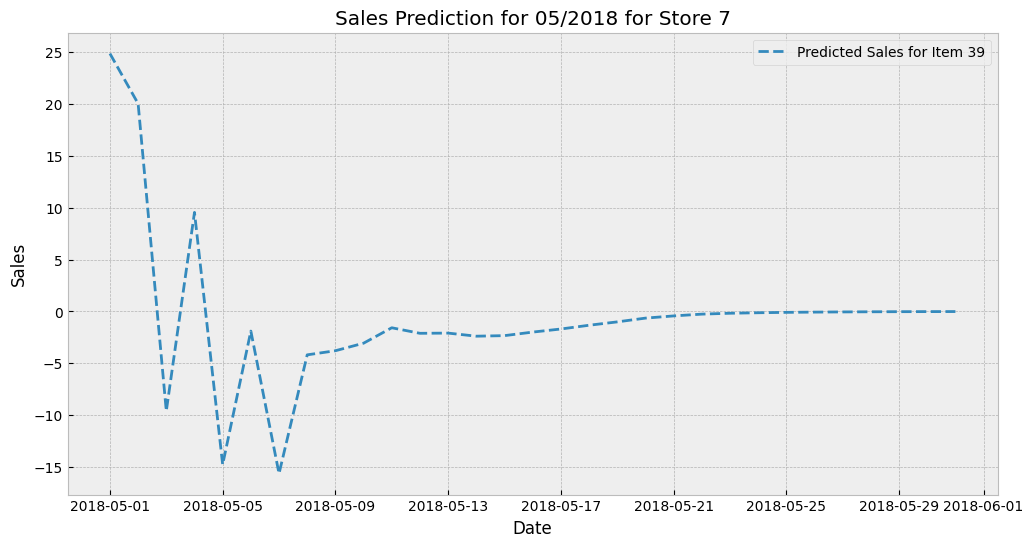

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
import sys
from datetime import timedelta

def validate_input(value, type_, min_value=None, max_value=None):
    try:
        value = type_(value)
        if min_value is not None and value < min_value:
            raise ValueError(f"Value must be at least {min_value}.")
        if max_value is not None and value > max_value:
            raise ValueError(f"Value must be at most {max_value}.")
        return value
    except ValueError as e:
        print(f"Invalid input: {e}")
        sys.exit(1)

def predict_future_sales(model, input_data, window_size):
    predictions = []
    current_data = input_data[-window_size:].reshape(1, window_size, 1)

    for _ in range(31):
        pred = model.predict(current_data)
        predictions.append(pred[0][0])
        current_data = np.append(current_data[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

    return predictions

def predict_sales_for_store(store, items, window_size):
    sales_predictions = {}
    for item in items:
        item_data = train[(train['store'] == store) & (train['item'] == item)]
        if item_data.empty:
            print(f"No data found for store {store} and item {item}")
            continue

        item_sales = item_data['sales'].values
        if len(item_sales) < window_size:
            print(f"Not enough data for store {store} and item {item} to form a window of size {window_size}")
            continue
        item_sales = item_sales.reshape((item_sales.shape[0], 1))

        windows = np.array([item_sales[i:i+window_size] for i in range(len(item_sales) - window_size + 1)])
        windows = windows.reshape((windows.shape[0], window_size, 1))

        future_sales_predictions = predict_future_sales(model_lstm, windows[-1:], window_size)
        sales_predictions[item] = future_sales_predictions

    return sales_predictions

train = pd.read_csv('/content/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/test.csv', parse_dates=['date'])


window_size = 29

store = validate_input(input("Enter the store number: "), int, min_value=1)
items = input("Enter the item numbers separated by commas: ").split(',')
items = [validate_input(item.strip(), int, min_value=1) for item in items]
month = validate_input(input("Enter the month (in MM format): "), str, min_value='01', max_value='12')

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dense(1))
adam = tf.keras.optimizers.Adam()
model_lstm.compile(loss='mse', optimizer=adam)

sales_predictions = predict_sales_for_store(store, items, window_size)

filtered_df = train[(train['date'].dt.month.astype(str).str.zfill(2) == month) & (train['date'].dt.year.between(2013, 2017))]
item_filtered_df = filtered_df[filtered_df['item'].isin(items)]

plt.figure(figsize=(12, 6))
for item in items:
    item_data = item_filtered_df[item_filtered_df['item'] == item]
    plt.plot(item_data['date'], item_data['sales'], marker='o', linestyle='-', label=f'Item {item}')

plt.title(f'Sales Data for Selected Month ({month}) from 2013 to 2017')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
start_date = pd.Timestamp(year=2018, month=int(month), day=1)
future_dates = [start_date + pd.Timedelta(days=i) for i in range(31)]

for item, predictions in sales_predictions.items():
    plt.plot(future_dates, predictions, label=f'Predicted Sales for Item {item}', linestyle='--')

plt.title(f'Sales Prediction for {month}/2018 for Store {store}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()
